# Making geologic cross sections from well logs

In [1]:
! pip install lasio

In [2]:
# let's import some packages we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import lasio
from textwrap import wrap  # for making pretty well names

%matplotlib inline

### Where did this data come from?
The cell below reads in the LAS file names using glob, and then reads in some fake tops I made up for the cross section. These are close to the top of the Niobrara Formation in the Denver Basin of southeast Wyoming. Well log LAS files are from the [WOGCC](http://pipeline.wyo.gov/legacywogcce.cfm) and tops are eyeballed by me and are probably way off.

In [3]:
wells = []
for name in glob.glob("logs/2014/*.las"):
    wells.append(name)

Now let's create a figure and read in well log. We then plot each log by subsea depth so we can see a structural cross section

In [58]:
def get_depth(well_log):
    try:
        return well_log["DEPT"]
    except:
        return well_log["DEPTH"]

def get_gamma(well_log):
    try:
        return well_log["GR"]
    except:
        return well_log["GRGC"]

In [59]:
len(wells)

3231

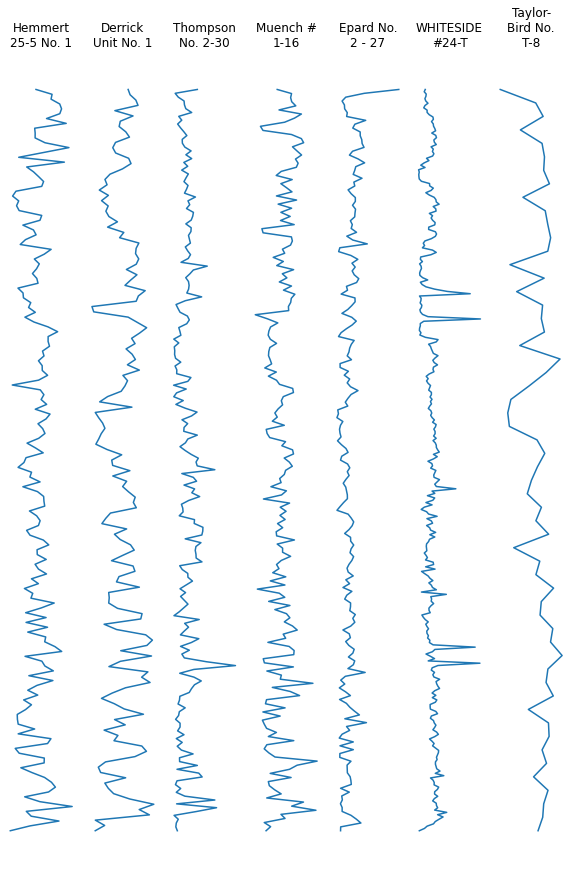

In [62]:
fig = plt.figure(figsize=(10, 15))  # set our figure size

for i, j in enumerate(range(28, 35)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    try:
        ax.plot(
            get_gamma(well_log)[::50],
            get_depth(well_log)[::50],
        )
    except Exception as e:
        print(e)
        print()
        pass
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    # we also downsample the logs so they plot faster
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun

That's a nice little cross section above, but can we make it better looking? More geologic styling to the gamma-ray curves is possible. Let's investigate this possibility. We will take our plot from above, and we're going to color between the curve and the right hand side. For a full breakdown look at the [coloring well logs notebook](https://github.com/jessepisel/5minutesofpython/blob/master/Well%20log%20plots/gamma%20ray%20colors.ipynb). One last thing we want to do is remove the whitespace between the logs so it looks better and we do that in the last line of the cell

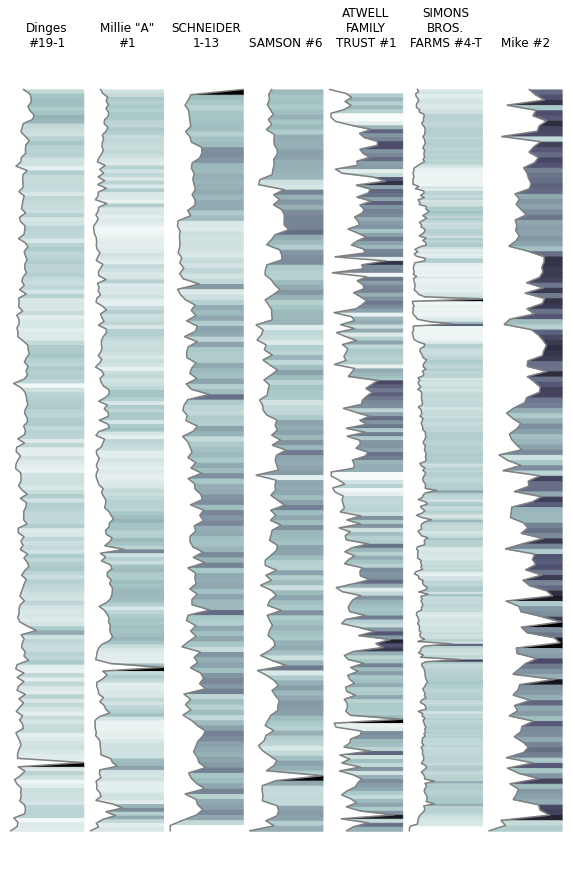

In [94]:
import matplotlib as mpl  # for making a colormap

cmap = mpl.cm.bone_r  # select our color map

fig = plt.figure(figsize=(10, 15))  # set our figure size


for i, j in enumerate(range(14, 21)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
             x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(wells[i])
        print(E)
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    ax.plot(x, y, color="gray")
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for k in range(x.size - 1):
        plt.fill_betweenx(
            [y[k], y[k + 1]],
            [x[k], x[k + 1]],
            x2=z.max(),
            color=cmap(normalize(z[k])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun
plt.subplots_adjust(wspace=0, hspace=0)

This notebook is licensed as CC-BY, use and share to your hearts content.

What else is in the well_log dataframe??

In [6]:
example_log = lasio.read(wells[0])
wells[0]

'logs/2014/1044839666.las'

Lets drop NaN's to see what is concistently there


In [7]:
example_df = example_log.df()
example_df

,BVTX,AVTX,RXORT,CILD,RLL3,SP,RILD,RILM,DCAL,RHOB,RHOC,DPOR,CNLS,GR,DGA,MCAL,MI,MN
DEPT,,,,,,,,,,,,,,,,,,
-1.0,0.0,0.0,NaN,NaN,100000.0,NaN,NaN,NaN,2.8636,-1.5648,-3.1316,249.9881,-4.9571,352.6158,NaN,NaN,NaN,NaN
-0.5,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.0,0.0,0.0,-28.7733,0.0000,50000.0,-333.0000,50000.0000,-499.6250,1.4312,-0.6938,-1.4650,119.8116,-2.4975,146.9875,NaN,NaN,NaN,NaN
0.5,0.0,0.0,-392.5096,66.8215,100000.0,-999.0000,14.9652,NaN,2.8613,-0.7261,-2.3105,200.9407,-4.8093,253.7774,NaN,NaN,NaN,NaN
1.0,0.0,0.0,-403.8156,117.4983,100000.0,-999.0000,8.5108,NaN,2.8611,-0.2107,-1.7720,170.7992,-4.4559,235.1165,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723.5,0.0,0.0,0.0000,0.0000,NaN,-50.2496,100000.0000,7.3005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9624,2.2530,3.7520
4724.0,0.0,0.0,0.0000,0.0000,NaN,-50.7174,100000.0000,7.5690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9617,2.2485,3.7498
4724.5,0.0,0.0,0.0000,0.0000,NaN,-51.2160,100000.0000,8.1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9583,2.2406,3.7426


In [8]:
well_log.df().dropna()["GR"]

DEPTH
3595.0    41.9691
3595.5    35.9293
3596.0    37.3332
3596.5    43.8515
3597.0    56.5548
           ...   
4780.0     1.6885
4780.5     0.2001
4781.0     0.0112
4781.5     0.0000
4805.5     0.0000
Name: GR, Length: 2375, dtype: float64

In [116]:
def plot_well(file_name):
    well_log = lasio.read(file_name)  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
            x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(file_name)
        print(E)
        raise Exception()
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    plt.plot(x, y, color="gray")
    ax = plt.gca()
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for j in range(x.size - 1):
        plt.fill_betweenx(
            [y[j], y[j + 1]],
            [x[j], x[j + 1]],
            x2=z.max(),
            color=cmap(normalize(z[j])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun
    plt.save("maps/" + "\n".join(well_log.well["WELL"].value, 10) + ".png")

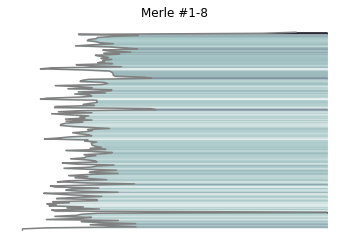

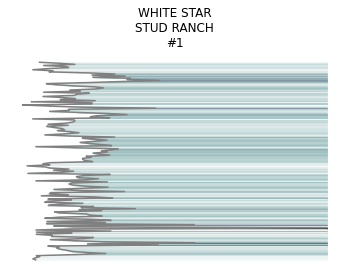

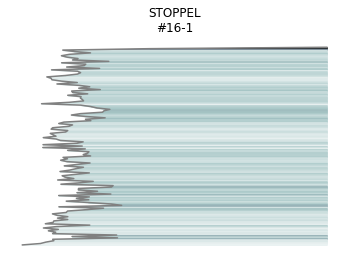

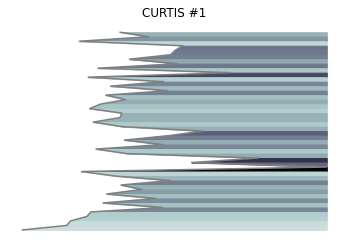

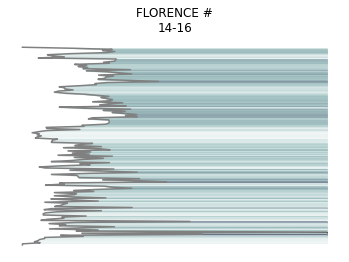

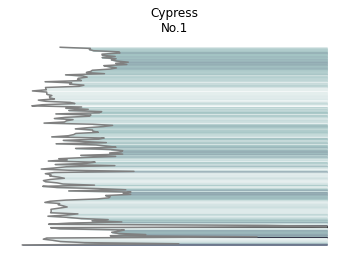

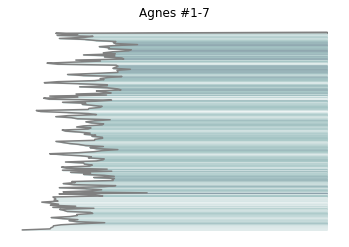

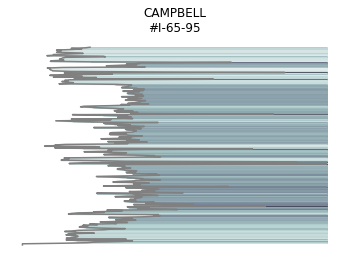

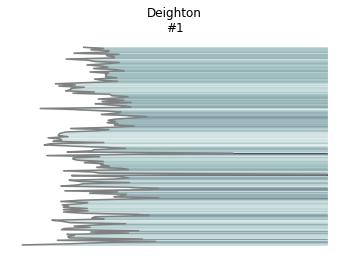

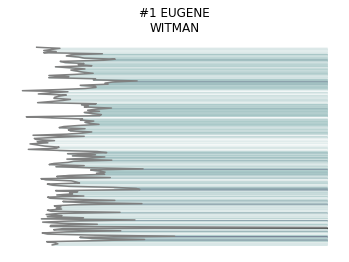

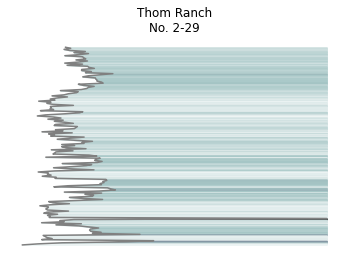

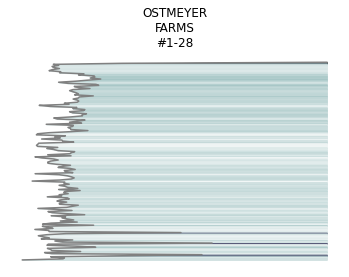

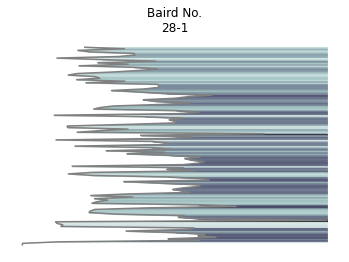

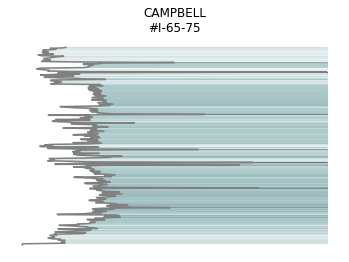

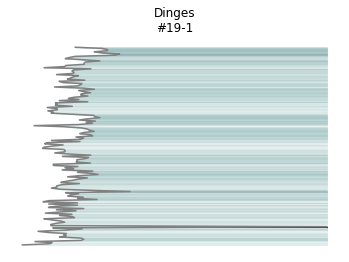

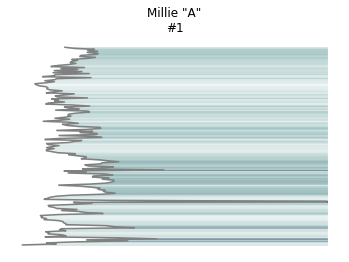

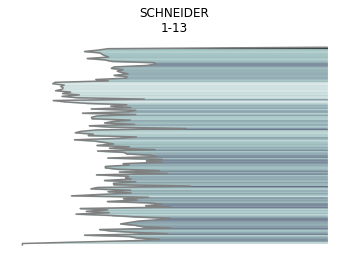

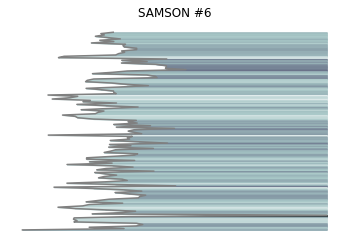

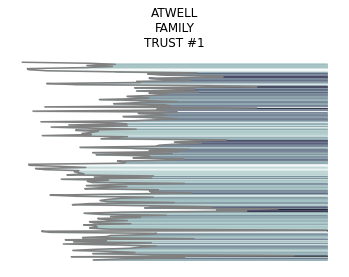

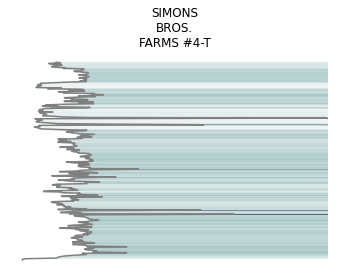

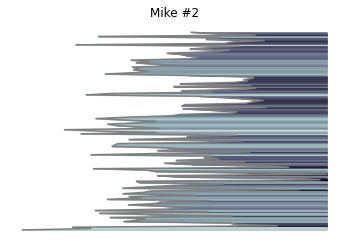

In [113]:
for i, well in enumerate(wells):
    plot_well(well)